In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import sklearn
import numpy as np
from math import sqrt

from tqdm.notebook import tqdm_notebook
import time

In [2]:
# Load the dataset of the normalised log-transformed data
expression_sc = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes.csv", index_col=0)

# Load the list of transcription factors
TFs = pickle.load(open("../../CAR_data/TF_list", "rb"))

# Import the dictionary of (grand)-parent nodes
parent_dict = pickle.load(open("../../CAR_data/upstream_node_dict", "rb"))

# Creates the genes list
genes = [k for k in expression_sc.columns if k not in ["CAR_Variant", "Type", "cell_type"]]

We'll follow Nicolas' idea to remove the lines:
For each cell, for each gene, compute the stdev of the Poisson distribution which is the square root of lambda, which is the mean of the distribution, which we estimate from the single value that we have.

Then we replace the initial value with a sample drawn form a uniform distribution centered around lambda with variance that of the Poisson (ie we draw in between $(x - x/2) and (x + x/2))


In [3]:
def compute_support_uniform(x):
    """ Compute the support of the uniform distribution we'll draw from for a datapoint with value x. """
    # The uniform distribution has support [a, b]
    # It has mean x = (a + b)/2
    # It has variance x = (b - a)**2/12
    # We have a system of equations s.t. a = 2*x - b and b**2 - 2*b*x + x**2 - 3x = 0
    
    # Solve the system by computing 
    # A = 1, B = -2x, C = x**2 - 3x
    # We take the positive root
    if x==0:
        return((0,0))
    delta = 4*(x**2)-4*(x**2-3*x)
    b =( 2*x + sqrt(delta))/2
    a = 2*x - b
    #print(f" x vaut {x}, the mean of the distribution is {(a+b)/2} and its variance is {(b-a)**2/12}.")
    return((a,b))

In [4]:
def add_Poisson_noise(x):
    """ Add Poisson noise to a datapoint with value x.
    """
    (a,b) = compute_support_uniform(x)
    a = max(a, 0)
    new_point = np.random.uniform(low = a, high = b)
    return(new_point)

In [5]:
def poissonize_dataframe(df, col_list):
    """ Add Poisson noise to a dataframe. Acts in place. """
    for col in col_list:
        print(col)
        df[col] = np.vectorize(add_Poisson_noise)(df[col])

In [6]:
expression_noise = expression_sc.copy()
poissonize_dataframe(expression_noise, genes)

CD28
PI3K
Lck
Grb2
GADS
Akt
ERK12
GSK3b
CD3z
PLCg1
MAPK
mTOR
Bad
cNFkB
NFAT
p38
Bcl2
BclXL
IL10
KLRG1
IRF4
CTLA4
IFNG
LEF1
G0S2
PRDM1
TNFRSF9
TCF7
GZMK
IL13
CDCA2
HAVCR1
LAG3
HAVCR2
CXCL8
ZNF683
FOXP1
IL1B
ID2
CSF2
CDK1
MKI67
GZMB
TNFRSF18
IL17RA
EOMES
CD160
CCL5
IL1A
LAYN
IL7R
LIF
CENPV
CD226
CD69
PDCD1
NCAM1
GNLY
BTLA
CCR7
NKG7
IL2
BATF
CCL1
CD27
CCNA2
STAT1
SELL
CCL3
BATF3
41BB
TRAF1
TRAF2
TRAF3
ncNFkB
ATF2
CEBPB
MEF2A
NFATC1
JUND
FOSL1
ATF1
MEF2C
ELK1
CEBPZ
ESR1
FOS
FOSL2
GATA1
HSF1
JUN
NANOG
RXRA
TAL1
BCL3
ELK4
GATA2
MYC
SP1
ETS1
IRF3
STAT3
GABPA
REST
E2F4
CD40
TRAF6
JAK3
STAT5
TNFa
IL6
ORC6
NCR1
ZEB2
PP2A
SHP2
SHP1
IL15Ra
Shc
JAK1
CCL20
TBX21
HOPX
ICOS
CCL4
CD244
TIGIT
cmyc
CD45
GZMH
CD2
KLF2
IL2RA
TNF
ENTPD1
PRF1
STAT5A
ADORA2A
TNFRSF4
KIR3DL1
GZMA
CD3E
RELA
IL16


In [7]:
expression_noise.to_csv("../../CAR_data/log_sc_expr_with_celltypes_with_noise.csv")

# See how this affects the data

In [56]:
parent_dict["STAT1"]

['ATF2',
 'BCL3',
 'CEBPB',
 'CTLA4',
 'E2F4',
 'ELK1',
 'ELK4',
 'ERK12',
 'ETS1',
 'FOS',
 'FOSL2',
 'GABPA',
 'GATA1',
 'GATA2',
 'JUN',
 'JUND',
 'MEF2A',
 'MEF2C',
 'MYC',
 'NFATC1',
 'REST',
 'RXRA',
 'SP1',
 'STAT1',
 'STAT3',
 'STAT5A',
 'TAL1',
 'cNFkB',
 'ncNFkB']

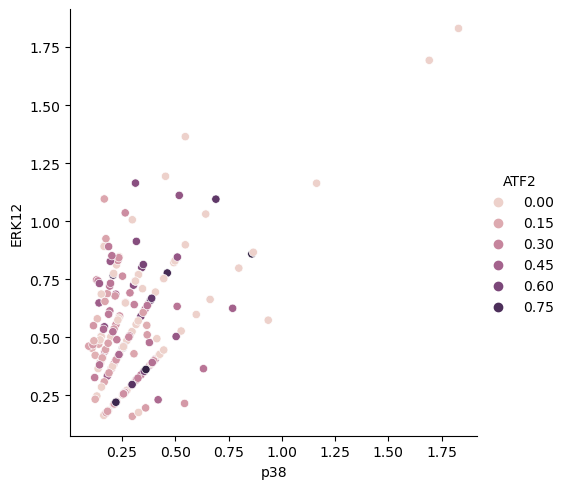

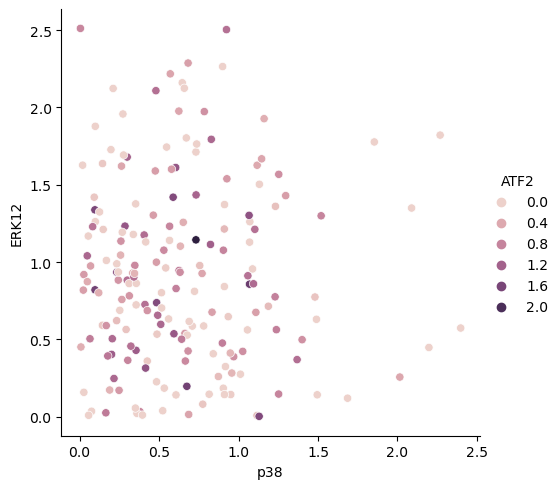

In [37]:
#fig, (ax1, ax2) = plt.subplots(2, 1)

zero = expression_sc[expression_sc["ERK12"]!= 0]
zero = zero[zero["p38"]!= 0]

ax1 = sns.relplot(
    data= zero[zero["p38"]!= 0],
    x="p38", y="ERK12", hue="ATF2",
    height=5, sizes=(5, 50),
)
zerobis = expression_noise[expression_noise["ERK12"]!= 0]
ax2 = sns.relplot(
    data= zerobis[zerobis["p38"]!=0],
    x="p38", y="ERK12", hue="ATF2",
    height=5, sizes=(5, 50),
)

In [38]:
zerobis = zerobis[zerobis["p38"]!= 0]

In [39]:
zerobis["ERK_bin"] = pd.cut(zerobis["ERK12"], 10, labels = False)

In [40]:
zerobis["p38_bin"]= pd.cut(zerobis["p38"], 10, labels = False)

In [41]:
zerobis_mean = zerobis.groupby(["p38_bin", "ERK_bin"])["ATF2"].mean().reset_index()

In [42]:
zerobis_mean

,p38_bin,ERK_bin,ATF2
0,0,0,0.386183
1,0,1,0.857327
2,0,2,0.510776
3,0,3,0.602633
4,0,4,0.433469
...,...,...,...
58,8,1,0.423420
59,8,5,0.000000
60,9,1,0.000000
61,9,2,0.000000


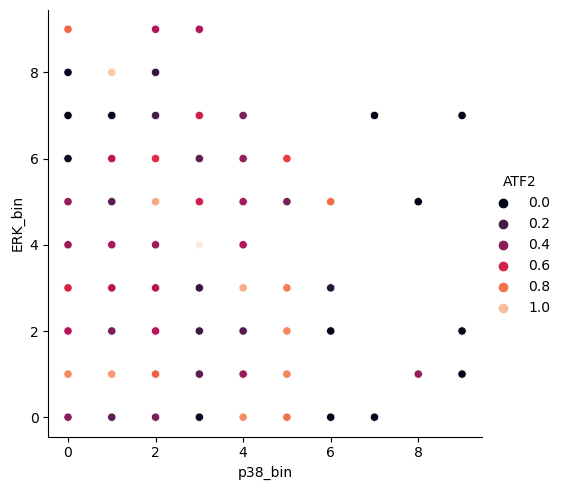

In [43]:
ax2 = sns.relplot(
    data= zerobis_mean,
    x="p38_bin", y="ERK_bin", hue="ATF2", palette = "rocket",
    height=5, sizes=(5, 50),
)

In [54]:
df2 = zerobis[zerobis["p38_bin"] == 4]

<AxesSubplot:xlabel='ERK12', ylabel='ATF2'>

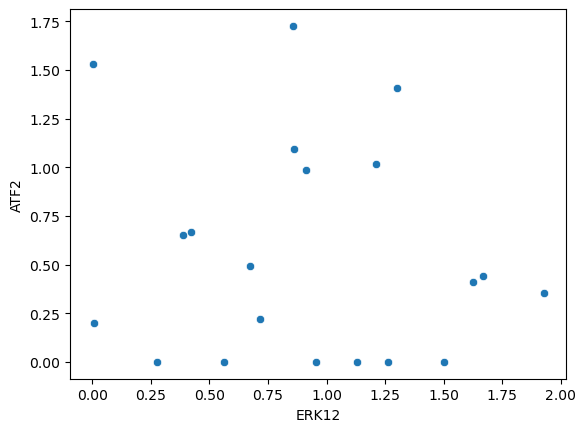

In [55]:
sns.scatterplot( x = df2["ERK12"], y = df2["ATF2"] )

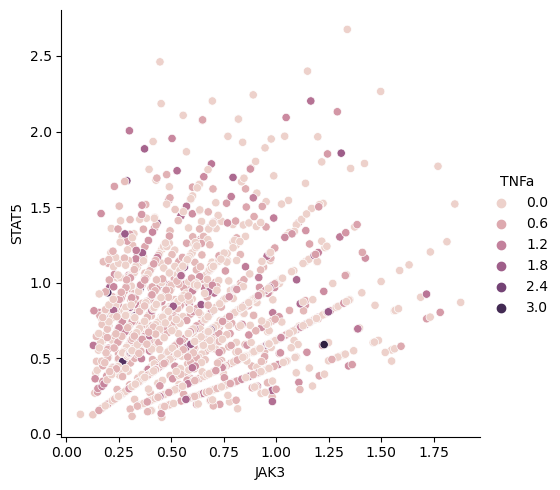

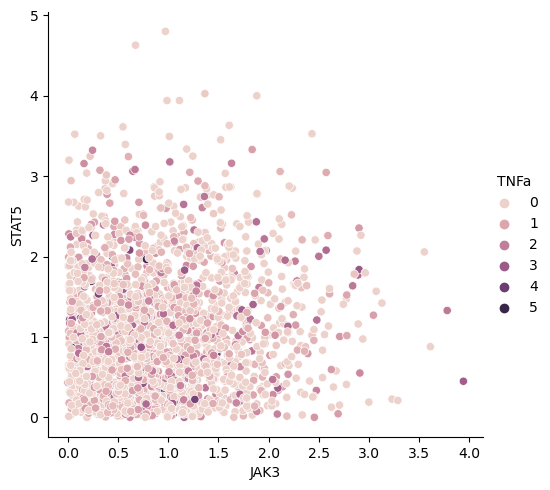

In [34]:
#fig, (ax1, ax2) = plt.subplots(2, 1)

zero = expression_sc[expression_sc["JAK3"]!= 0]

ax1 = sns.relplot(
    data= zero[zero["STAT5"]!= 0],
    x="JAK3", y="STAT5", hue="TNFa",
    height=5, sizes=(5, 50),
)
zerobis = expression_noise[expression_noise["JAK3"]!= 0]
ax2 = sns.relplot(
    data= zerobis[zerobis["STAT5"]!=0],
    x="JAK3", y="STAT5", hue="TNFa",
    height=5, sizes=(5, 50),
)

In [35]:
zerobis = zerobis[zerobis["STAT5"]!=0]
zerobis["STAT_bin"] = pd.cut(zerobis["STAT5"], 10, labels=False)
zerobis["JAK_bin"] = pd.cut(zerobis["JAK3"], 10, labels=False)
zerobis_mean = zerobis.groupby(["STAT_bin", "JAK_bin"])["TNFa"].mean().reset_index()

/tmp/ipykernel_403886/1644815356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zerobis["STAT_bin"] = pd.cut(zerobis["STAT5"], 10, labels=False)
/tmp/ipykernel_403886/1644815356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zerobis["JAK_bin"] = pd.cut(zerobis["JAK3"], 10, labels=False)


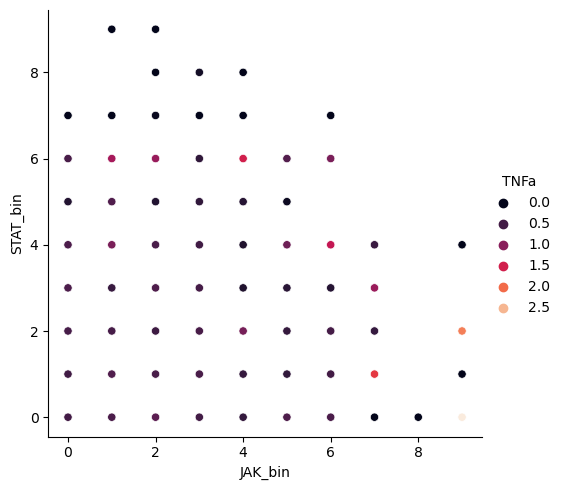

In [36]:
ax2 = sns.relplot(
    data= zerobis_mean,
    x="JAK_bin", y="STAT_bin", hue="TNFa", palette = "rocket",
    height=5, sizes=(5, 50),
)

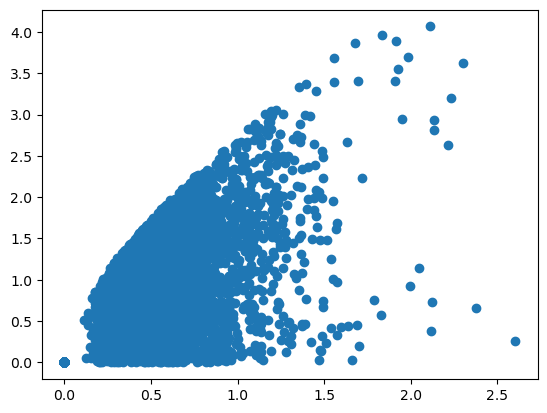

In [9]:
#fig, (ax1, ax2) = plt.subplots(2, 1)

plt.scatter(x = expression_sc["ERK12"], y = expression_noise["ERK12"])

In [10]:
expression_sc[expression_sc["ERK12"]== 0 ]["ERK12"]

AAACGAAAGGTAAGGA-1-1      0.0
AAACGAAGTACGCGTC-1-1      0.0
AAAGGGCTCGAGCCAC-1-1      0.0
AAAGGTATCCATCCGT-1-1      0.0
AAAGTCCAGCGTATGG-1-1      0.0
                         ... 
TTCTAGTGTGCTGTCG-1-TCR    0.0
TTCTAGTTCACACCGG-1-TCR    0.0
TTGATGGGTGGACAGT-1-TCR    0.0
TTGGGCGAGCGTGCCT-1-TCR    0.0
TTGTTTGTCTATGCCC-1-TCR    0.0
Name: ERK12, Length: 1675, dtype: float64

In [11]:
zero = expression_sc[expression_sc["ERK12"]== 0 ]
poissonize_dataframe(zero, genes)
zero["ERK12"]

CD28
PI3K
Lck
Grb2


/tmp/ipykernel_403886/4045914810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.vectorize(add_Poisson_noise)(df[col])


GADS
Akt
ERK12
GSK3b
CD3z
PLCg1
MAPK
mTOR
Bad
cNFkB
NFAT
p38
Bcl2
BclXL
IL10
KLRG1
IRF4
CTLA4
IFNG
LEF1
G0S2
PRDM1
TNFRSF9
TCF7
GZMK
IL13
CDCA2
HAVCR1
LAG3
HAVCR2
CXCL8
ZNF683
FOXP1
IL1B
ID2
CSF2
CDK1
MKI67
GZMB
TNFRSF18
IL17RA
EOMES
CD160
CCL5
IL1A
LAYN
IL7R
LIF
CENPV
CD226
CD69
PDCD1
NCAM1
GNLY
BTLA
CCR7
NKG7
IL2
BATF
CCL1
CD27
CCNA2
STAT1
SELL
CCL3
BATF3
41BB
TRAF1
TRAF2
TRAF3
ncNFkB
ATF2
CEBPB
MEF2A
NFATC1
JUND
FOSL1
ATF1
MEF2C
ELK1
CEBPZ
ESR1
FOS
FOSL2
GATA1
HSF1
JUN
NANOG
RXRA
TAL1
BCL3
ELK4
GATA2
MYC
SP1
ETS1
IRF3
STAT3
GABPA
REST
E2F4
CD40
TRAF6
JAK3
STAT5
TNFa
IL6
ORC6
NCR1
ZEB2
PP2A
SHP2
SHP1
IL15Ra
Shc
JAK1
CCL20
TBX21
HOPX
ICOS
CCL4
CD244
TIGIT
cmyc
CD45
GZMH
CD2
KLF2
IL2RA
TNF
ENTPD1
PRF1
STAT5A
ADORA2A
TNFRSF4
KIR3DL1
GZMA
CD3E
RELA
IL16


AAACGAAAGGTAAGGA-1-1      0.0
AAACGAAGTACGCGTC-1-1      0.0
AAAGGGCTCGAGCCAC-1-1      0.0
AAAGGTATCCATCCGT-1-1      0.0
AAAGTCCAGCGTATGG-1-1      0.0
                         ... 
TTCTAGTGTGCTGTCG-1-TCR    0.0
TTCTAGTTCACACCGG-1-TCR    0.0
TTGATGGGTGGACAGT-1-TCR    0.0
TTGGGCGAGCGTGCCT-1-TCR    0.0
TTGTTTGTCTATGCCC-1-TCR    0.0
Name: ERK12, Length: 1675, dtype: float64